<a href="https://colab.research.google.com/github/Zainaazar/Tweets-Sentiment-Analysis-Streamlit-project/blob/main/twitter_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#🧠 Twitter Sentiment Analysis using Hybrid LSTM-GRU Model
A Natural Language Processing project that analyzes tweets and classifies them into four sentiment categories: Positive, Negative, Neutral, and Irrelevant.

In [ ]:
pip install gensim emoji contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.1/345.1 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 5.1 MB/s eta 0:00:00


In [ ]:
# ============================================================
# 📦 Importing Required Libraries
# ============================================================

import re
import pickle
import emoji
import contractions
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, GRU, Embedding, Dropout, Bidirectional, SpatialDropout1D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

from gensim.models import Word2Vec
import kagglehub
import os


In [ ]:
# ============================================================
# 📦 Downloading Required Packages
# ============================================================
nltk.download('punkt')          # For tokenization
nltk.download('stopwords')      # For stopword removal
nltk.download('wordnet')        # For lemmatization (optional)
nltk.download('omw-1.4')        # Support files for wordnet (optional)
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('maxent_ne_chunker_tab')
nltk.download('words')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package maxent_ne_chunker_tab to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker_tab.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nl

True

## 🧾 Step 1: Data Loading

In [ ]:
# Download dataset from Kaggle
path = kagglehub.dataset_download("jp797498e/twitter-entity-sentiment-analysis")
print("Dataset path:", path)

# Load CSV files
train_df = pd.read_csv(f"{path}/twitter_training.csv", encoding='latin-1')
test_df = pd.read_csv(f"{path}/twitter_validation.csv", encoding='latin-1')


100%|██████████| 1.99M/1.99M [00:00<00:00, 45.4MB/s]

Extracting files...


Dataset path: /root/.cache/kagglehub/datasets/jp797498e/twitter-entity-sentiment-analysis/versions/2


 Exploring The Data EDA using pandas

In [ ]:
train_df.head()

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [ ]:
train_df.tail()

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
74676,9200,Nvidia,Positive,Just realized that the Windows partition of my...
74677,9200,Nvidia,Positive,Just realized that my Mac window partition is ...
74678,9200,Nvidia,Positive,Just realized the windows partition of my Mac ...
74679,9200,Nvidia,Positive,Just realized between the windows partition of...
74680,9200,Nvidia,Positive,Just like the windows partition of my Mac is l...


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74681 entries, 0 to 74680
Data columns (total 4 columns):
 #   Column                                                 Non-Null Count  Dtype 
---  ------                                                 --------------  ----- 
 0   2401                                                   74681 non-null  int64 
 1   Borderlands                                            74681 non-null  object
 2   Positive                                               74681 non-null  object
 3   im getting on borderlands and i will murder you all ,  73995 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [ ]:
train_df.columns

Index(['2401', 'Borderlands', 'Positive',
       'im getting on borderlands and i will murder you all ,'],
      dtype='object')

In [ ]:
train_df.drop(['Borderlands', '2401'], axis=1, inplace= True)

In [ ]:
train_df.columns = train_df.columns.str.strip()
train_df.rename(columns={"Positive": 'Sentiment', 'im getting on borderlands and i will murder you all ,': 'Tweet' },
                inplace= True)

In [ ]:
test_df.head()

,3364,Facebook,Irrelevant,"I mentioned on Facebook that I was struggling for motivation to go for a run the other day, which has been translated by Tomâs great auntie as âHayley canât get out of bedâ and told to his grandma, who now thinks Iâm a lazy, terrible person ð¤£"
0,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
1,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
2,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
3,4433,Google,Neutral,Now the President is slapping Americans in the...
4,6273,FIFA,Negative,Hi @EAHelp Iâve had Madeleine McCann in my c...


In [ ]:
test_df.columns

Index(['3364', 'Facebook', 'Irrelevant',
       'I mentioned on Facebook that I was struggling for motivation to go for a run the other day, which has been translated by Tomâs great auntie as âHayley canât get out of bedâ and told to his grandma, who now thinks Iâm a lazy, terrible person ð¤£'],
      dtype='object')

In [ ]:
test_df.drop(['3364', 'Facebook'], axis=1, inplace= True)

In [ ]:
test_df.columns = test_df.columns.str.strip()
test_df.rename(columns={"Irrelevant": 'Sentiment', 'I mentioned on Facebook that I was struggling for motivation to go for a run the other day, which has been translated by Tomâs great auntie as âHayley canât get out of bedâ and told to his grandma, who now thinks Iâm a lazy, terrible person ð¤£': 'Tweet' },
                inplace= True)

In [ ]:
# Combine for uniform preprocessing
combined_df = pd.concat([train_df, test_df], axis=0, ignore_index=True)

In [ ]:
combined_df.head()

,Sentiment,Tweet
0,Positive,I am coming to the borders and I will kill you...
1,Positive,im getting on borderlands and i will kill you ...
2,Positive,im coming on borderlands and i will murder you...
3,Positive,im getting on borderlands 2 and i will murder ...
4,Positive,im getting into borderlands and i can murder y...


In [ ]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75680 entries, 0 to 75679
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentiment  75680 non-null  object
 1   Tweet      74994 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


In [ ]:
#filling na with most frequent
most_frequent_tweet = combined_df['Tweet'].mode()[0]
combined_df['Tweet'].fillna(most_frequent_tweet, inplace=True)

/tmp/ipython-input-1651225491.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  combined_df['Tweet'].fillna(most_frequent_tweet, inplace=True)


In [ ]:
combined_df.isnull().sum()

,0
Sentiment,0
Tweet,0


#🧹 Step 2: Data Cleaning & Preprocessing

Lowercase all text

Remove punctuation and URLs

Replace emojis and contractions

Tokenize, lemmatize, and remove stopwords

Keep negations like “not”

applying on one sample to check the right methods to do

In [ ]:
# picking a random sample
sample= combined_df["Tweet"][300]

In [ ]:
sample= sample.lower()

In [ ]:
#tokenize
tokenizer= word_tokenize(sample)

In [ ]:
tokenizer

['psycho',
 'krieg',
 'and',
 'the',
 'fantastic',
 'fustercluck',
 'is',
 'a',
 'wonderful',
 'conclusion',
 'to',
 'the',
 'borderlands',
 '3',
 'dlc',
 'line',
 ',',
 'which',
 'focuses',
 'on',
 'a',
 'fan',
 'favorite',
 'character',
 'and',
 'offers',
 'long-lasting',
 'players',
 'a',
 'conclusion',
 'on',
 'some',
 'very',
 'big',
 'issues',
 'of',
 'the',
 'character',
 'of',
 'war',
 'and',
 'memorable',
 'set',
 'pieces',
 'with',
 'which',
 'players',
 'interact',
 '.']

In [ ]:
#removing Punctuations
punctuations = r'[@#.,!?;:$%^&*()\-_=+{}[\]<>|\\/"]'

after_reg = []
for i in tokenizer:
    reg = re.sub(punctuations, '', i)       # remove punctuation
    reg = re.sub('[^a-zA-Z]', '', reg)      # keep only letters
    after_reg.append(reg)

after_reg


['psycho',
 'krieg',
 'and',
 'the',
 'fantastic',
 'fustercluck',
 'is',
 'a',
 'wonderful',
 'conclusion',
 'to',
 'the',
 'borderlands',
 '',
 'dlc',
 'line',
 '',
 'which',
 'focuses',
 'on',
 'a',
 'fan',
 'favorite',
 'character',
 'and',
 'offers',
 'longlasting',
 'players',
 'a',
 'conclusion',
 'on',
 'some',
 'very',
 'big',
 'issues',
 'of',
 'the',
 'character',
 'of',
 'war',
 'and',
 'memorable',
 'set',
 'pieces',
 'with',
 'which',
 'players',
 'interact',
 '']

In [ ]:
#stemming
after_stem=[]
stemmer= SnowballStemmer("english", ignore_stopwords=True)
for i in after_reg:
  stem= stemmer.stem(i)
  after_stem.append(stem)
print(after_stem)

['psycho', 'krieg', 'and', 'the', 'fantast', 'fustercluck', 'is', 'a', 'wonder', 'conclus', 'to', 'the', 'borderland', '', 'dlc', 'line', '', 'which', 'focus', 'on', 'a', 'fan', 'favorit', 'charact', 'and', 'offer', 'longlast', 'player', 'a', 'conclus', 'on', 'some', 'very', 'big', 'issu', 'of', 'the', 'charact', 'of', 'war', 'and', 'memor', 'set', 'piec', 'with', 'which', 'player', 'interact', '']


In [ ]:
#Lemmatizing
after_lemm=[]
lemma= WordNetLemmatizer()
for i in after_stem:
  lem= lemma.lemmatize(i)
  after_lemm.append(lem)
print(after_lemm)

['psycho', 'krieg', 'and', 'the', 'fantast', 'fustercluck', 'is', 'a', 'wonder', 'conclus', 'to', 'the', 'borderland', '', 'dlc', 'line', '', 'which', 'focus', 'on', 'a', 'fan', 'favorit', 'charact', 'and', 'offer', 'longlast', 'player', 'a', 'conclus', 'on', 'some', 'very', 'big', 'issu', 'of', 'the', 'charact', 'of', 'war', 'and', 'memor', 'set', 'piec', 'with', 'which', 'player', 'interact', '']


In [ ]:
# removing stop words
from nltk.corpus import stopwords
stopwords= set(stopwords.words("english"))
after_stopwords=[]
for i in after_lemm:
  if i not in stopwords:
    after_stopwords.append(i)
print(after_stopwords)

['psycho', 'krieg', 'fantast', 'fustercluck', 'wonder', 'conclus', 'borderland', '', 'dlc', 'line', '', 'focus', 'fan', 'favorit', 'charact', 'offer', 'longlast', 'player', 'conclus', 'big', 'issu', 'charact', 'war', 'memor', 'set', 'piec', 'player', 'interact', '']


##preprocessing the data

In [ ]:
from nltk.corpus import stopwords # Import stopwords again

stop_words = set(stopwords.words('english')) - {'not', 'no', 'nor'}
lemmatizer = WordNetLemmatizer()

corpus = []
for text in combined_df["Tweet"]:
    text = text.lower()
    text = contractions.fix(text)
    text = re.sub(r'http\S+|www\S+', ' URL ', text)
    text = re.sub(r'@\w+', ' USER ', text)
    text = re.sub(r'#(\w+)', r'\1', text)
    text = emoji.demojize(text)
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()

    tokens = word_tokenize(text)
    clean_tokens = [lemmatizer.lemmatize(t) for t in tokens if t not in stop_words and len(t) > 1]
    corpus.append(" ".join(clean_tokens))

In [ ]:
corpus[1:8]

['getting borderland kill',
 'coming borderland murder',
 'getting borderland murder',
 'getting borderland murder',
 'spent hour making something fun not know huge USER fan maya one favorite character decided make wallpaper pc original image versus creation made enjoy pic twitter com mlsi wf jg',
 'spent couple hour something fun not know huge borderland fan maya one favorite character decided make wallpaper pc original picture compared creation made fun pic twitter com mlsi wf jg',
 'spent hour something fun not know huge borderland fan maya one favorite character']

##🧩 Step 3: Word2Vec Embedding

Word2Vec transforms words into numerical vectors that capture their semantic meaning. This helps the LSTM and GRU layers learn contextual relationships between words.

In [ ]:
 # split back into list of words
tokenized_corpus= [sentence.split() for sentence in corpus]

In [ ]:
#tarin the word2vec model
model= Word2Vec( sentences= tokenized_corpus,
        vector_size= 100,
        window= 7,
        min_count= 1,
        workers= 4
)

In [ ]:
vector = model.wv['love']
vector.shape

(100,)

In [ ]:
# Convert texts to sequences of integers
tok= tf.keras.preprocessing.text.Tokenizer()
tok.fit_on_texts(tokenized_corpus)
sequences=tok.texts_to_sequences(tokenized_corpus)
print(sequences[70:74])

[[22, 784, 3128, 60, 26, 181, 133, 459, 191, 344, 11, 123, 533, 156], [22, 224, 10, 82, 6172, 166, 62], [22, 224, 36, 166, 82, 6172, 62], [22, 224, 10, 1757, 6172, 166, 22, 62]]


In [ ]:
vocab_size = len(tok.word_index) + 1  # +1 for padding token
print("Vocabulary size:", vocab_size)

Vocabulary size: 27015


 Padding Sequences

In [ ]:
# for padding need to get the longest sequence that the algorithm found Max Len
max_len_seq= max(len(i) for i in sequences)
max_len_seq

130

In [ ]:
# Padding sequences
padded_sequences= tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen= max_len_seq, padding= "pre" )

In [ ]:
type(padded_sequences)

numpy.ndarray

In [ ]:
padded_sequences[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,  284, 1757,  201], dtype=int32)

In [ ]:
combined_df['Sentiment'].value_counts()

,count
Sentiment,
Negative,22808
Positive,21108
Neutral,18603
Irrelevant,13161


##Creating XY predictors and labels


In [ ]:
x= np.array(padded_sequences)# Map each sentiment string to a unique integer
mapping = {
    'Negative': 0,
    'Positive': 1,
    'Neutral': 2,
    'Irrelevant': 3
}

y = combined_df['Sentiment'].map(mapping)

# Convert to numpy array
y_mapped = np.array(y)

# Convert to categorical with 4 classes
y_cat = tf.keras.utils.to_categorical(y_mapped, num_classes=4)

In [ ]:
x_train, x_test, y_train, y_test= train_test_split(x,y_cat, test_size= 0.2, random_state= 42)

# ⚙️ Step 4: Model Preparation and Building

##A Bidirectional LSTM + GRU hybrid model to leverage both sequential memory and efficiency in processing text data.

In [ ]:
model_hybrid = Sequential()
model_hybrid.add(Embedding(vocab_size, 100, input_length=max_len_seq))
model_hybrid.add(SpatialDropout1D(0.3))
model_hybrid.add(Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.001))))
model_hybrid.add(GRU(32, kernel_regularizer=l2(0.001)))
model_hybrid.add(Dropout(0.3))
model_hybrid.add(Dense(4, activation="softmax", kernel_regularizer=l2(0.001)))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

In [ ]:
model_hybrid.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
early_stop = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=1e-3)

#🧮 Step 5: Model Training

###The model was trained using the Adam optimizer with a small learning rate and monitored for validation accuracy.
###Early stopping and learning rate reduction were used to prevent overfitting.

In [ ]:
history = model_hybrid.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=1,
    validation_split=0.2,
    shuffle=True
)

Epoch 1/50
1892/1892 ━━━━━━━━━━━━━━━━━━━━ 42s 21ms/step - accuracy: 0.3562 - loss: 1.5501 - val_accuracy: 0.5856 - val_loss: 1.0786 - learning_rate: 1.0000e-04
Epoch 2/50
1892/1892 ━━━━━━━━━━━━━━━━━━━━ 39s 20ms/step - accuracy: 0.6245 - loss: 0.9931 - val_accuracy: 0.6808 - val_loss: 0.8512 - learning_rate: 1.0000e-04
Epoch 3/50
1892/1892 ━━━━━━━━━━━━━━━━━━━━ 38s 20ms/step - accuracy: 0.7385 - loss: 0.7505 - val_accuracy: 0.7574 - val_loss: 0.7007 - learning_rate: 1.0000e-04
Epoch 4/50
1892/1892 ━━━━━━━━━━━━━━━━━━━━ 38s 20ms/step - accuracy: 0.8035 - loss: 0.5981 - val_accuracy: 0.7904 - val_loss: 0.6165 - learning_rate: 1.0000e-04
Epoch 5/50
1892/1892 ━━━━━━━━━━━━━━━━━━━━ 41s 20ms/step - accuracy: 0.8364 - loss: 0.5124 - val_accuracy: 0.8142 - val_loss: 0.5670 - learning_rate: 1.0000e-04
Epoch 6/50
1892/1892 ━━━━━━━━━━━━━━━━━━━━ 38s 20ms/step - accuracy: 0.8585 - loss: 0.4517 - val_accuracy: 0.8222 - val_loss: 0.5301 - learning_rate: 1.0000e-04
Epoch 7/50
1892/1892 ━━━━━━━━━━━━━━━━━━━

In [ ]:
model_hybrid.summary()# wont work before model.fit


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (32, 130, 100)         │     2,701,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_1             │ (32, 130, 100)         │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (32, 130, 128)         │        84,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (32, 32)               │        15,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (32, 32)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 4)                │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,404,994 (32.06 MB)

 Trainable params: 2,801,664 (10.69 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,603,330 (21.38 MB)

#📊 Step 6: Evaluation & Results

In [ ]:
y_pred= model_hybrid.predict(x_test)

473/473 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step


In [ ]:
y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)
acc_score= accuracy_score(y_test_labels, y_pred_labels)
acc_score

0.867600422832981

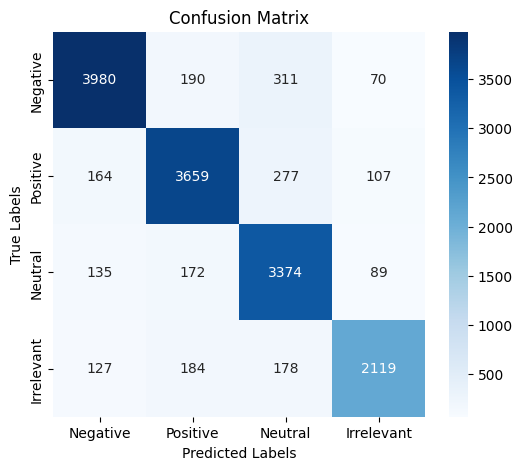

Accuracy Score: 0.867600422832981

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.87      0.89      4551
           1       0.87      0.87      0.87      4207
           2       0.81      0.89      0.85      3770
           3       0.89      0.81      0.85      2608

    accuracy                           0.87     15136
   macro avg       0.87      0.86      0.87     15136
weighted avg       0.87      0.87      0.87     15136



In [ ]:
#calssification report
c_r= classification_report(y_test_labels, y_pred_labels)

# Compute confusion matrix
cm = confusion_matrix(y_test_labels, y_pred_labels)
labels = ['Negative', 'Positive', 'Neutral', 'Irrelevant']
# Plot
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

print("Accuracy Score:", acc_score)
print("\nClassification Report:\n", c_r)

📋 Classification Report Explanation

The classification report provides detailed evaluation metrics for each sentiment class.

Metric	Meaning
Precision	Out of all tweets the model predicted as a given class, how many were actually correct.
→ Measures prediction accuracy per class.
Recall	Out of all tweets that truly belong to a class, how many the model correctly identified.
→ Measures how well the model captures all examples of that class.
F1-Score	The harmonic mean of Precision and Recall.
→ Balances both false positives and false negatives. A high F1 means consistent accuracy and coverage.
Support	The number of true samples for each class in the test data.

📈 Interpretation:

Higher precision = fewer wrong predictions.

Higher recall = fewer missed examples.

F1-score combines both, making it a good overall indicator of class performance.

🧠 In this project:

Positive and Negative classes achieved the highest F1-scores, meaning the model understands clear sentiment expressions well.

Neutral and Irrelevant are slightly lower, which is expected since they can overlap semantically.

✅ Overall, the model shows strong, balanced performance and captures sentiment trends effectively across different categories.

In [ ]:
# Convert one-hot encoded to numeric labels
y_test_classes = np.argmax(y_test, axis=1)

# Define the mapping
label_map = {
    0: 'Negative',
    1: 'Positive',
    2: 'Neutral',
    3: 'Irrelevant'
}

# Create DataFrame
df_ytest = pd.DataFrame({'encoded_label': y_test_classes})
df_ytest['class_name'] = df_ytest['encoded_label'].map(label_map)

# Get class counts
class_counts = df_ytest['class_name'].value_counts()
print(class_counts)

class_name
Negative      4551
Positive      4207
Neutral       3770
Irrelevant    2608
Name: count, dtype: int64


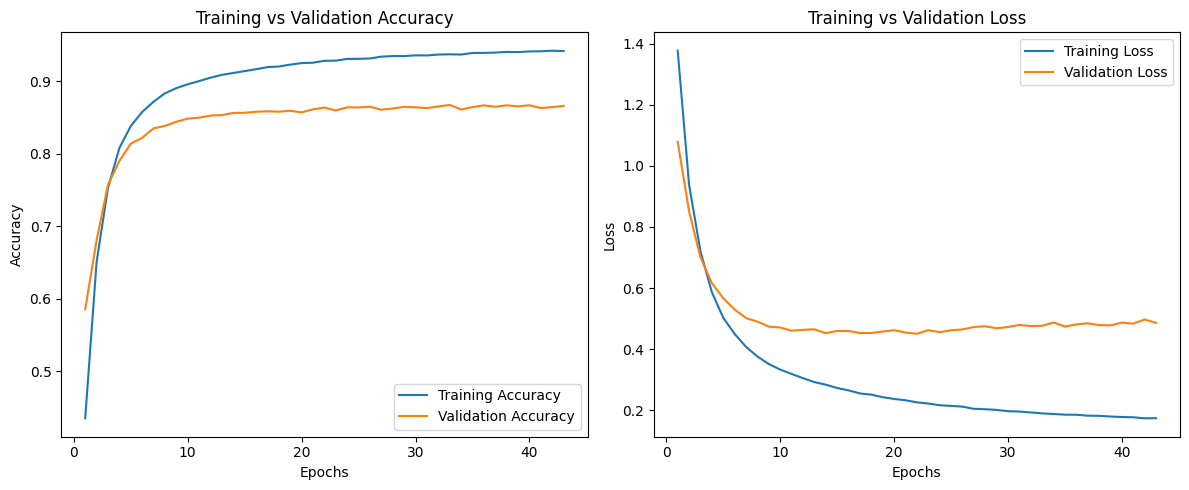

In [ ]:
# Accuracy and loss plots

# Retrieve training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(acc) + 1)

# Accuracy plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()

📊 Model Performance Evaluation

After training, the model’s performance was evaluated using accuracy, loss, and a confusion matrix.

🔹 Accuracy and Loss

Training Accuracy: Measures how well the model learned from the training data.

Validation Accuracy: Shows how well the model performs on unseen data during training.

Training Loss: Indicates how much error the model makes on the training data.

Validation Loss: Measures the error on validation data.

📈 Observation:
From the plots above, both training and validation accuracy increase steadily while losses decrease, showing that the model learned effectively without severe overfitting.

🧩 Confusion Matrix Interpretation

The confusion matrix visualizes how many tweets were correctly or incorrectly classified for each sentiment class.

Class	Meaning	Count (in test data)
0	Negative	4551
1	Positive	4207
2	Neutral	3770
3	Irrelevant	2608

# 💾 Step 7: Saving the Model and Tokenizer

In [ ]:
model_hybrid.save("hybrid_model.keras")
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tok, f)

# Load later in Streamlit
# with open("tokenizer.pkl", "rb") as f:
#     tokenizer = pickle.load(f)



In [ ]:
model_hybrid.save("hybrid_model.keras")  # safer and preferred in TF 2.15+


#🔍 Step 8: Prediction Function

In [ ]:
label_map = {
    0: 'Negative',
    1: 'Positive',
    2: 'Neutral',
    3: 'Irrelevant'
}

def predict_sentiment(text):
    # Clean and tokenize (using the previously fitted tok object)
    seq = tok.texts_to_sequences([text])
    padded = pad_sequences(seq, maxlen= max_len_seq, padding='post', truncating='post')

    # Predict (using the trained model_hybrid)
    pred = model_hybrid.predict(padded)
    label_index = np.argmax(pred, axis=1)[0]
    sentiment = label_map[label_index]

    return sentiment

In [ ]:
# test the model
print(predict_sentiment("funny"))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Positive


🏁 Summary

✅ Model Architecture: Bidirectional LSTM + GRU
✅ Optimizer: Adam (lr = 0.0001)
✅ Loss: Categorical Crossentropy
✅ Accuracy: ~ 0.87
✅ Purpose: Classify Twitter sentiments into four categories